In [1]:
import os
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from bs4 import BeautifulSoup
import spacy

from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from google.cloud import storage
from google.colab import drive
from google.colab import files
from google.api_core import datetime_helpers

PROJECT_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26'
TITANIC_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26/titanic'
KEYS_PATH = '/content/drive/MyDrive/Kaggle/bq-4-26/keys'
KEY = 'kaggle-colab-4-26-3e8884497243.json'
KEY_PATH = os.path.join(KEYS_PATH, KEY)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = KEY_PATH

In [2]:
kaggle_initialize = False

In [3]:
# !pip list

# os.chdir(KEYS_PATH)
# !pwd
# !ls

# KAGGLE SETUP
if kaggle_initialize:
  
  os.chdir('/content/drive/MyDrive/Kaggle')
  !ls

  # Upload kaggle API key file
  uploaded = files.upload()

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !ls ~/.kaggle

  !kaggle --version

  # # Trends brain data download
  os.chdir(DATASET_PATH)
  !kaggle competitions download -c trends-assessment-prediction

  # # titanic dataset download

  os.chdir(DATASET_PATH)
  os.chdir('bq-4-26/titanic')
  !pwd

  !kaggle competitions download -c titanic

# Big Query Functions
Client object creation requires authentication setup <br>
https://cloud.google.com/bigquery/docs/reference/libraries

Using big query to take a csv from google drive and run some queries and dataframe transformations. <br>

Datasets can be created in BigQuery's GUI or by command.

In [4]:
bq_initialize = False

In [5]:
if bq_initialize:
  
  %load_ext google.colab.data_table
  # to revert back to standard data table display methods
  # %unload_ext google.colab.data_table

  # Setting API target
  PROJECT_ID = 'kaggle-colab-4-26'
  dataset_name = 'titanic'
  table_name = 'train'

  # Construct a bigquery client object
  client = bigquery.Client(PROJECT_ID)

## Project Details

In [6]:
# List all datasets and tables in project
def listBQProjectElements(project_id):

  project = client.project
  datasets = client.list_datasets()

  # List datasets given project
  if datasets:
    print("Project: {}".format(project))
    for dataset in datasets:
      print("Datasets: {}".format(dataset.dataset_id))
      tables = client.list_tables(dataset.dataset_id)
      for table in tables:
        print("\t\tTables: {}".format(table.table_id))
  else:
    print("{} project does not contain any datasets".format(project))

# Output table properties
def getTableProperties(table_ref):
  table = client.get_table(table_ref)
  print("Schema:")
  display(table.schema)
  print("\nDescription:")
  display(table.description)
  print("\nNumber of Rows:")
  display(table.num_rows)

## Assigning Object Variables

In [7]:
# Assign dataset objects
def getDatasetObjects(dataset_name, display=True):
  dataset_id = client.project + "." + dataset_name
  dataset_ref = client.dataset(dataset_name)
  # dataset_fqid = bigquery.Dataset(dataset_id) # forced and object does not have attributes even though it prints the same
  dataset_fqid = client.get_dataset(dataset_ref) # same as dataset_fqid using reference isntead of id
  
  if display:
    print("Dataset ID (String): \t\t{}".format(dataset_id))
    print("Dataset Reference: \t\t{}".format(dataset_ref))
    print("Dataset Fully Qualified ID: \t{}".format(dataset_fqid))
 
  return dataset_id, dataset_ref, dataset_fqid


# Assign Table Objects
def getTableObjects(dataset_name, table_name, dislpay=True):
  dataset_id, dataset_ref, dataset_fqid = getDatasetObjects(dataset_name, display=False)
  table_id = dataset_id + "." + table_name
  table_ref = dataset_ref.table(table_name)
  # table_fqid = bigquery.Table(table_id) # forced and object does not have attributes even though it prints the same
  table_fqid = client.get_table(table_ref) # same as table_fqid using reference instead of table_id

  if display:
    print("Table ID (String): \t\t{}".format(table_id))
    print("Table Reference: \t\t{}".format(table_ref))
    print("Table Fully Qualified ID: \t{}".format(table_fqid))

  return table_id, table_ref, table_fqid

## Creation and Deletion

In [8]:
# Create new dataset
def createDataset(dataset_name):
# new_dataset = "new_dataset"
# client.create_dataset(new_dataset)
  pass


# Delete dataset
def deleteDataset(dataset_name):
  pass


# Create new table in dataset
def createTable(dataset_ref, table_name):
  table_ref = dataset_ref.table(table_name)
  if not doesTableExist(table_ref):
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print("Table {} has been created.".format(table_name))


# Delete table in dataset
def deleteTable(dataset_ref, table_name):
  table_ref = dataset_ref.table(table_name)
  if doesTableExist(table_ref):
    table = bigquery.Table(table_ref)
    client.delete_table(table)
    print("Table {} has been deleted.".format(table_name))


# Creates table and populates with CSV contents in dataset
def populateTableFromCSV(dataset_fqid, table_fqid, file_csv=0):
  if not doesTableExist(table_fqid):
    print("ready to create table")
    job_config = bigquery.LoadJobConfig()
    job_config.source_format = bigquery.SourceFormat.CSV
    job_config.autodetect = True

    with open(file_csv, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_fqid, job_config = job_config)
    
    job.result()
    print("Loaded {} rows into {}:{}.".format(job.output_rows, dataset_fqid.dataset_id, table_fqid.table_id))
  else:
    print("table already exists")


## Checks


In [9]:
# Check if dataset exists
def doesDatasetExist(dataset_fqid):
  try:
    client.get_dataset(dataset_fqid)
    print("Dataset {} exists.".format(dataset_fqid.dataset_id))
    return True
  except NotFound:
    print("Dataset {} not found.".format(dataset_fqid.dataset_id))


# Check if table exists
def doesTableExist(table_fqid):
  try:
    client.get_table(table_fqid)
    print("Table {} exists.".format(table_fqid.table_id))
    return True
  except NotFound:
    print("Table {} is not found.".format(table_fqid.table_id))

# Uploading Titanic Training Dataset to Big Query Dataset

In [10]:
titanic_bq = False

First check the contents of the project tree


In [11]:
if titanic_bq:
  listBQProjectElements(PROJECT_ID)

Assign object variables for the target dataset and table for ease of use in later functions. <br>

Documentation and errors may reference the ID in both string or fully-qualified notation.  This can be thought of as the difference between hostname vs FQDN.

In [12]:
if titanic_bq:
  titanic_id, titanic_ref, titanic_fqid = getDatasetObjects(dataset_name)
  print("\n")
  train_id, train_ref, train_fqid = getTableObjects(dataset_name, table_name)
  print("\n")

  # Verify dataset and table existence
  doesDatasetExist(titanic_fqid)
  doesTableExist(train_fqid)

The table will be deleted in order to perform a clean upload.<br>
Schema, description, and rows are verified.

In [13]:
if titanic_bq:
  deleteTable(titanic_fqid, "train")
  populateTableFromCSV(titanic_fqid, train_fqid, 'train.csv')
  print("\n")
  getTableProperties(train_ref)

## Saving Table Snapshot
Mistakes can be undone in multiple ways:
- Create and revert to a snapshot <br>
https://googleapis.dev/python/bigquery/latest/usage/tables.html

- Use decorators for time travel <br>
https://cloud.google.com/bigquery/docs/time-travel#restore-a-table

- Backup table to another table for external use <br>
https://medium.com/google-cloud/how-to-backup-a-bigquery-table-or-dataset-to-google-cloud-storage-and-restore-from-it-6ef7eb322c6d


In [14]:
# Creating a snapshot

def createTableSnapshot(table_id):
  snapshot_epoch = int(time.time() * 1000)
  print(snapshot_epoch)
  # Ensuring that the snapshot is newer than the creation of the table
  # Otherwise, revert to the creation of the table 
  table = client.get_table(table_id)

  created_epoch = datetime_helpers.to_milliseconds(table.created)
  if created_epoch > snapshot_epoch:
    snapshot_epoch = created_epoch

  return snapshot_epoch

def revertTableToSnapshot(dataset_id, table_id, snapshot_epoch, recovery_table_name):
  recovered_table_id = dataset_id + "." + recovery_table_name
  
  try:
    recovered_table_fqid = client.get_table(recovered_table_id)
    print("Table {} already exists".format(recovery_table_name))

  except NotFound:
    print("Table does not already exist. Recovering {}.".format(recovery_table_name))
      # Construct the restore-from table ID using a snapshot decorator.
    snapshot_table_id = "{}@{}".format(table_id, snapshot_epoch)

    # Construct and run a copy job.
    job = client.copy_table(
        snapshot_table_id,
        recovered_table_id,
        # Must match the source and destination tables location.
        location="US",
    )  # Make an API request.

    job.result()  # Wait for the job to complete.

    print(
        "Copied data from deleted table {} to {}".format(table_id, recovered_table_id)
    )


**Snapshot Test**

1. Verify project contents
2. Create a snapshot
3. Delete "train" table
4. Revert snapshot with new name "train2"
5. Verify project contents

In [15]:
if titanic_bq:
  # Verify project contents
  listBQProjectElements(PROJECT_ID)

  # Create a snapshot
  print("\nTimestamp for snapshot:")
  train_snapshot_4_28_2021_17_11 = createTableSnapshot(train_id)

In [16]:
if titanic_bq:
  # Delete "train" table
  deleteTable(titanic_ref, "train")


  # Revert snapshot with new name "train2"
  print("\n")
  revertTableToSnapshot(titanic_id, train_id, train_snapshot_4_28_2021_17_11, "train2")

  # Verify project contents
  print("\n")
  listBQProjectElements(PROJECT_ID)

After verifying, the name can be reverted.  The only other method I'm aware of is to copy to a new dataset and/or table.

In [17]:
if titanic_bq:
  deleteTable(titanic_ref, "train2")

  # recheck datasets
  print("\n")
  listBQProjectElements(PROJECT_ID)

  # revert with original name
  print("\n")
  revertTableToSnapshot(titanic_id, train_id, train_snapshot_4_28_2021_17_11, "train")

  # recheck datasets
  print("\n")
  listBQProjectElements(PROJECT_ID)

# Accessing Data

## Run A Query As An API Request Using Standard SQL

https://googleapis.dev/python/bigquery/latest/index.html

In [18]:
bq_access_data = False

In [19]:
if bq_access_data:
  query = f"""
  SELECT *
  FROM {PROJECT_ID}.titanic.train
  """
  query_job = client.query(query)
  df1 = query_job.to_dataframe()
  print(df1.shape)
  df1.head()

In [20]:
if bq_access_data:
  df1.sort_values('Fare', ascending=False).head()

## Run Query Using gbq And Pandas
https://cloud.google.com/bigquery/docs/pandas-gbq-migration

In [21]:
if bq_access_data:

  df2 = pd.io.gbq.read_gbq('''
    SELECT Name, SUM(Fare) As total
    FROM `kaggle-colab-4-26.titanic.train`
    GROUP BY Name
    ORDER BY total DESC
  ''', project_id=PROJECT_ID, dialect='standard')

  df2.head()

## Paging Through Tables

https://cloud.google.com/bigquery/docs/paging-results

In [22]:
if bq_access_data:
  client.list_rows(train_fqid, selected_fields=train_fqid.schema[:3], max_results=5).to_dataframe()

# Big Query Public Dataset Exploration - Stack Overflow Dataset


List all tables from dataset

In [23]:
bq_stackoverflow = False

In [24]:
if bq_stackoverflow:

  dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")
  dataset = client.get_dataset(dataset_ref)
  tables = list(client.list_tables(dataset))

  for table in tables:
    print(table.table_id)
    table_ref = client.get_table(table)
    print(table_ref.num_rows)
    print(table_ref.description)
    display(table_ref.schema)


Tables to investigate: Valuable columns<br>
- badges: date, name, user_id, class
- post_history: id, date, user_id, text
- post_answers: id, body, creation_date, score
- posts_questions: id, title, body, aceepted_answer_id, answer_count, comment_count, creation_date, favorit_count, score, tags, view_count
- posts_tag_wiki
- posts_tag_wiki_excerpt
- tags: id, count, excerpt_post_id, wiki_post_id
- users: id, reputation, up_votes, down_votes, website_url


## Posts Answers

In [25]:
if bq_stackoverflow:

  so_posts_answers_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*)
    FROM `bigquery-public-data.stackoverflow.posts_answers` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_posts_answers_count.head())

  so_posts_answers_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.posts_answers` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_posts_answers_df.head(1)

In [26]:
if bq_stackoverflow:
  so_posts_answers_df.describe()

In [27]:
if bq_stackoverflow:
  so_posts_answers_df.isna().sum()

## Posts Questions

In [28]:
if bq_stackoverflow:
  so_posts_questions_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*)
    FROM `bigquery-public-data.stackoverflow.posts_questions` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_posts_questions_count.head())

  so_posts_questions_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.posts_questions` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_posts_questions_df.head(1)

In [29]:
if bq_stackoverflow:
  so_posts_questions_df.describe()

In [30]:
if bq_stackoverflow:
  so_posts_questions_df.isna().sum()

## Questions and Answers min/max between April '16 and April '21 
For all questions that have an accepted answer

In [31]:
if bq_stackoverflow:
  so_QA_min_max = pd.io.gbq.read_gbq('''
   SELECT
      MIN(pq.view_count) AS q_min_views, MAX(pq.view_count) AS q_max_views, 
      MIN(pq.score) AS q_min_score, MAX(pq.score) AS q_max_score,
      MIN(pq.favorite_count) AS q_min_fav, MAX(pq.favorite_count) AS q_max_fav, 
      MIN(pq.answer_count) AS q_min_answers, MAX(pq.answer_count) AS q_max_answers,
      MIN(pq.comment_count) AS q_min_comment_count, MAX(pq.comment_count) AS q_max_comment_count, 

      MIN(pa.view_count) AS a_min_views, MAX(pa.view_count) AS a_max_views, 
      MIN(pa.score) AS a_min_score, MAX(pa.score) AS a_max_score,
      MIN(pa.comment_count) AS a_min_comment_count, MAX(pa.comment_count) AS a_max_comment_count, 
  FROM `bigquery-public-data.stackoverflow.posts_questions` AS pq
  JOIN `bigquery-public-data.stackoverflow.posts_answers` AS pa ON pq.accepted_answer_id = pa.id
  WHERE pq.creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_QA_min_max

## <font color='red'>Questions With Accepted Answers (JOINED)</font>


In [32]:

if bq_stackoverflow:
  so_posts_QA_df = pd.io.gbq.read_gbq('''
  SELECT pq.title, pq.body AS post_question, pa.body AS post_answer, pq.answer_count AS question_answers, 
          pq.comment_count AS question_comments, pa.comment_count AS answer_comments, pq.creation_date, pq.last_activity_date, 
          pq.score AS question_score, pa.score AS answer_score, pq.tags, pq.view_count AS question_view_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` AS pa
  INNER JOIN (
      SELECT *
      FROM `bigquery-public-data.stackoverflow.posts_questions`
      WHERE accepted_answer_id IS NOT NULL
      AND creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
  ) AS pq ON pa.id = pq.accepted_answer_id
  WHERE RAND() < 200000 / 4362034

  -- can also join to find the owner of the answer
  ;
  ''', dialect='standard')

  so_posts_QA_df.head(2)

In [33]:
if bq_stackoverflow:
  so_posts_QA_df.isna().sum()

In [34]:
if bq_stackoverflow:
  so_posts_QA_df.shape
  so_posts_QA_df['question_score'].describe()
  so_posts_QA_df.info()

### Saving dataframes as parquet and feather formats 

In [35]:
saving_df = False

In [36]:
if saving_df:
  # Navigate to google drive location

  os.chdir('/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow')
  !ls

In [37]:
if saving_df:
  # Save file as parquet
  #so_posts_QA_df.to_parquet('so_posts_QA_df.parquet.gzip', compression='gzip')

  so_posts_QA_df.to_parquet('so_posts_QA_parquet.parquet.gzip', compression='gzip')

  # Save file as feather
  so_posts_QA_df.to_feather('so_posts_QA_feather')

In [38]:
if saving_df:
  # Read back parquet file and verify column types

  so_posts_QA = pd.read_parquet('so_posts_QA_parquet.parquet.gzip')
  so_posts_QA.info()

In [39]:
if saving_df:
  # read back feather file and verify column types

  so_posts_QA_feather_df = pd.read_feather('so_posts_QA_feather')
  so_posts_QA_feather_df.info()

### Distribution of numerical values 
- question_answers
- question_comments
- answer_comments
- question_score
- answer_score
- question_view_count

In [40]:
dist_checks = False

In [41]:
if dist_checks:
  # Count Plot


  plt.figure(figsize=(15,10))
  sns.countplot(x='answer_score', data=so_posts_QA_df)
  plt.yscale("log")
  plt.xscale("linear")
  plt.xlim(-25, 250)
  ticks = range(-24, 300, 15)
  plt.xticks(ticks)
  plt.show()


In [42]:
if dist_checks:
  plt.figure()
  sns.kdeplot(so_posts_QA_df["answer_score"])
  plt.yscale("log")
  plt.show()

In [43]:
if dist_checks:
  plt.figure()
  sns.countplot(x='answer_score', data=so_posts_QA_df)
  plt.yscale("log")
  plt.xscale("log")
  plt.show()

In [44]:
if dist_checks:
  # subplots of all cont features in so_posts_QA_df

  cont_features = ['question_answers', 'question_view_count', 'question_comments', 'answer_comments', 'question_score', 'answer_score']
  plt.subplots(3,2, figsize=(10,15))
  plt.suptitle('distribution of continuous features')

  for i, col in enumerate(cont_features, 1):
    plt.subplot(3,2,i)
    sns.countplot(x=so_posts_QA_df[col])
    xrange = range(so_posts_QA_df[col].min(), so_posts_QA_df[col].max(), round((so_posts_QA_df[col].max()-so_posts_QA_df[col].min())/15) )
    plt.title(col)
    plt.xticks(xrange)
    plt.yscale("log")
  plt.tight_layout
  plt.show()

## Posts Tag Wiki Excerpt

In [45]:
if bq_stackoverflow:
  so_posts_tag_wiki_excerpt_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*) as full_count
    FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` 
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_posts_tag_wiki_excerpt_count.head())

  so_posts_tag_wiki_excerpt_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_posts_tag_wiki_excerpt_df.head(1)

In [46]:
if bq_stackoverflow:
  so_posts_tag_wiki_excerpt_df.isna().sum()

## Tags

In [47]:
if bq_stackoverflow:
  so_tags_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*) as full_count
    FROM `bigquery-public-data.stackoverflow.tags` 
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_tags_count.head())

  so_tags_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.tags` 
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_tags_df.head(1)

In [48]:
if bq_stackoverflow:
  so_tags_df.describe()

In [49]:
if bq_stackoverflow:
  so_tags_df.isna().sum()

## All Tags And Excerpts (JOINED)

In [50]:
if bq_stackoverflow:
  so_tags_full = pd.io.gbq.read_gbq('''
  SELECT t.tag_name, te.body, t.count, te.comment_count, te.creation_date, te.last_activity_date, te.score, 
  FROM `bigquery-public-data.stackoverflow.posts_tag_wiki_excerpt` AS te
  JOIN `bigquery-public-data.stackoverflow.tags` as t ON te.id = t.excerpt_post_id
  ;
  ''',dialect='standard')

  so_tags_full.info()

  so_tags_full.head(2)

## Users

In [51]:
if bq_stackoverflow:
  so_users_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*) as five_year_count
    FROM `bigquery-public-data.stackoverflow.users` 
    WHERE creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_users_count.head())

  so_users_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.users` 
    WHERE creation_date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_users_df.head(1)

In [52]:
if bq_stackoverflow:
  so_users_df.describe()

In [53]:
if bq_stackoverflow:
  so_users_df['reputation'].unique()

In [54]:
if bq_stackoverflow:
  so_users_df.info()

## Badges

In [55]:
if bq_stackoverflow:
  so_badges_count = pd.io.gbq.read_gbq('''
    SELECT COUNT(*)
    FROM `bigquery-public-data.stackoverflow.badges` 
    WHERE date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  display(so_badges_count.head())

  so_badges_df = pd.io.gbq.read_gbq('''
    SELECT *
    FROM `bigquery-public-data.stackoverflow.badges` 
    WHERE date BETWEEN TIMESTAMP("2020-04-01") AND TIMESTAMP("2021-04-01")
    LIMIT 1000
  ;
  ''', project_id=PROJECT_ID, dialect='standard')

  so_badges_df.head(1)

In [56]:
if bq_stackoverflow:
  so_badges_df['name'].unique()

-- LIST USERS IN THE LAST 10 YEARS.
-- : MOST UPVOTES, MOST BADGES (STRING_AGG), 

In [57]:
if bq_stackoverflow:
  so_user_badges = pd.io.gbq.read_gbq('''
    SELECT b.user_id, u.display_name,
        STRING_AGG(DISTINCT b.name, ", ") AS applied_badges,
        SUM(u.down_votes) AS total_downvotes,
        SUM(u.up_votes) AS total_upvotes,
        SUM(u.reputation) AS total_reputation
    FROM `bigquery-public-data.stackoverflow.users` AS u
    JOIN `bigquery-public-data.stackoverflow.badges` AS b ON u.id = b.user_id
    WHERE u.creation_date BETWEEN TIMESTAMP("2011-04-01") AND TIMESTAMP("2021-04-01")
    GROUP BY b.user_id, u.display_name
    ORDER BY total_reputation DESC 
    LIMIT 300000
    ;
  ''', project_id=PROJECT_ID, dialect='standard')

In [58]:
if bq_stackoverflow:
  so_user_badges.shape

## Final Queries for NLP EDA

- Questions and accepted answers in last 5 years with 'python' tag
- tags with the most 'count'

In [59]:
nlp_eda = True

In [60]:
if nlp_eda:

  os.chdir('/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow')
  !pwd
  !ls

/content/drive/MyDrive/Kaggle/bq-4-26/stackoverflow
 nlp_answer_pipeline_epoch-5_batch-128	    nlp_pipeline_epoch-5_batch-128
 nlp_answer_pipeline_epoch-5_batch-256	    nlp_pipeline_epoch-5_batch-256
 nlp_answer_pipeline_epoch-5_batch-512	    nlp_pipeline_epoch-5_batch-512
'nlp_default_pipeline_epoch-5_batch-256 '   so_posts_QA_df.parquet.gzip
 nlp_default_pipeline_epoch-5_batch-512     so_posts_QA_feather
 nlp_pipeline_epoch-10_batch-512	    so_QA_tags.gzip


In [61]:
if bq_stackoverflow:
  so_QA_tags_df = pd.io.gbq.read_gbq('''
  SELECT pq.title, pq.body AS post_question, pa.body AS post_answer, pq.answer_count AS question_answers, 
         pq.comment_count AS question_comments, pa.comment_count AS answer_comments, pq.creation_date, pq.last_activity_date, 
         pq.score AS question_score, pa.score AS answer_score, pq.tags, pq.view_count AS question_view_count
  FROM `bigquery-public-data.stackoverflow.posts_answers` AS pa
  INNER JOIN (
      SELECT *
      FROM `bigquery-public-data.stackoverflow.posts_questions`
      WHERE accepted_answer_id IS NOT NULL
      AND creation_date BETWEEN TIMESTAMP("2016-04-01") AND TIMESTAMP("2021-04-01")
      AND tags LIKE "%python%"
  ) AS pq ON pa.id = pq.accepted_answer_id
  WHERE RAND() < 200000 / 586000
  ''', dialect='standard') 

  print(so_QA_tags_df.shape)

  so_QA_tags_df.to_parquet("so_QA_tags.gzip", compression='gzip')

In [62]:
if nlp_eda:
  so_QA_tags = pd.read_parquet("so_QA_tags.gzip")
  so_QA_tags.head(2)

# Query Types

- JOIN
- UNION
- GROUP CONCAT
- COALESCE
- LAG, LEAD
- CASE/WHEN/THEN/ELSE, IF/ELSEIF/ELSE
<br>

- String Manipulation
- Datetime Manipulation
- Aggregate Functions
<br>

- Subqueries
- Window Functions
  - PARTITION BY
- CTE (Common Table Expressions)



# NLP
How does the question content and accepted answer content affect the following metrics?:
- upvotes
- downvotes
- reputation
- badges


**Regression** <br>

*Logistic*
1. Can the question title and body be enough to predict the majority of votes (up/down).  Whether the post is good or bad.
<br>

*Linear*
1. Assuming a good post, can the number of views be predicted depending on how long the question has been live?  This will require some feature engineering to know the number of years a question has been around.

2. Is there a trend in certain techniques/keywords for certain tags?

*Unsupervised Clustering*
1. Which tags have the most activity in the last 5 years?

## Question/Answer title and body analysis using NLP libraries

- beautiful soup: Parse through HTML and clean up tags
- create new column for links and if links were included
- nltk: tokenization
- spacy: independent effort

-- remove \n nextline
-- remove punctuation
-- stopwords
-- create word cloud for tags
-- stemming
-- lemmatization



In [63]:

print(so_QA_tags.shape)
so_QA_tags.head(2)

(199679, 12)


,title,post_question,post_answer,question_answers,question_comments,answer_comments,creation_date,last_activity_date,question_score,answer_score,tags,question_view_count
0,"Click: Customize ""Missing argument"" error hand...",<p>I´m currently trying to customize the error...,<p>This is a first draft and the most naive so...,1,4,3,2020-04-27 17:54:28.800000+00:00,2020-04-28 20:43:47.557000+00:00,1,1,python|command-line-interface|command-line-arg...,143
1,'list' object is not callable for checking sco...,<p>I am creating a model using SVM. I wanted t...,<p>You create lists:</p>\n<pre><code>accuracy ...,1,2,0,2020-07-14 06:42:41.183000+00:00,2020-07-16 14:20:51.563000+00:00,2,2,python|scikit-learn|jupyter|svm|confusion-matrix,129


In [64]:
print(so_QA_tags.shape)
so_QA_tags.describe().T

(199679, 12)


,count,mean,std,min,25%,50%,75%,max
question_answers,199679.0,1.571487,0.973870,1.0,1.0,1.0,2.0,32.0
question_comments,199679.0,1.862519,2.520400,0.0,0.0,1.0,3.0,47.0
answer_comments,199679.0,1.514401,2.318252,0.0,0.0,1.0,2.0,61.0
question_score,199679.0,1.188222,5.993023,-22.0,0.0,0.0,1.0,1296.0
answer_score,199679.0,2.137170,8.225570,-5.0,0.0,1.0,2.0,1643.0
question_view_count,199679.0,1211.418161,7036.489821,7.0,52.0,137.0,676.0,965492.0


In [65]:
print(so_QA_tags.question_view_count.median())
print(so_QA_tags.question_view_count.mode())

137.0
0    37
dtype: int64


#### Distribution for views

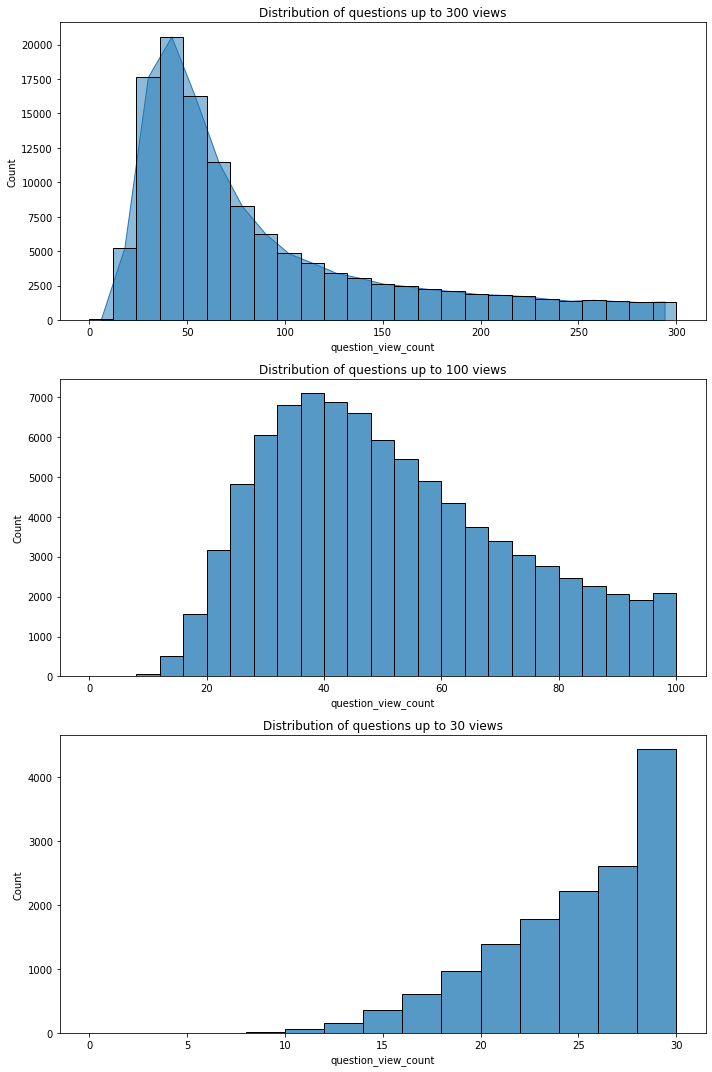

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(10,15))

ax1 = axes[0]
ax1.set_title('Distribution of questions up to 300 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,300), bins=25, ax=ax1, alpha=.5)
sns.histplot(x='question_view_count', data=so_QA_tags, element='poly', binrange=(0,300), bins=25, ax=ax1, alpha=.5)

ax2 = axes[1]
ax2.set_title('Distribution of questions up to 100 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,100), bins=25, ax=ax2)

ax3 = axes[2]
ax3.set_title('Distribution of questions up to 30 views')
sns.histplot(x='question_view_count', data=so_QA_tags, binrange=(0,30), bins=15, ax=ax3)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

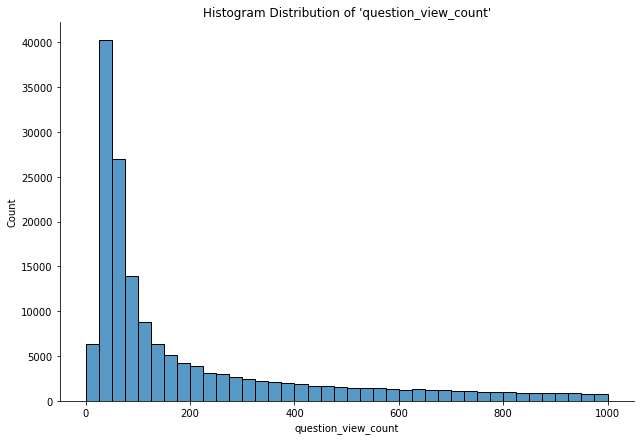

In [67]:
# fig, ax = plt.subplots(figsize=(10,15))
plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='hist', binrange=(0,1000), bins=40, height=6, aspect=1.5)
plt.title("Histogram Distribution of 'question_view_count'")
plt.show()



<Figure size 432x288 with 0 Axes>

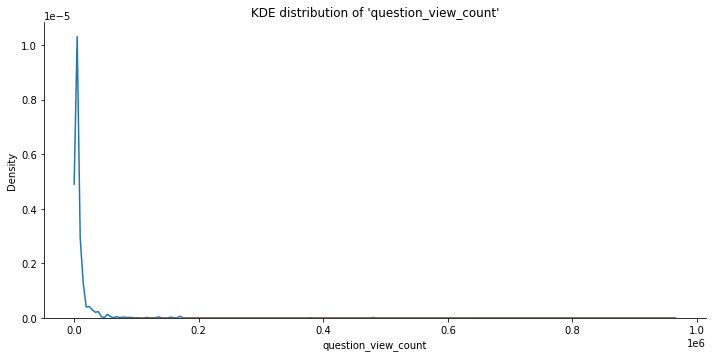

<Figure size 432x288 with 0 Axes>

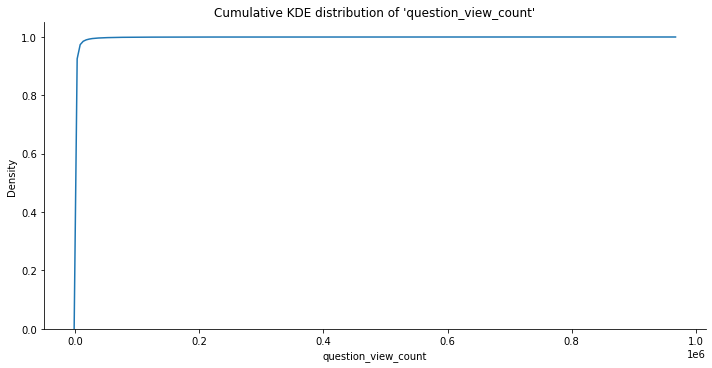

In [68]:

plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='kde', bw_adjust=.1, aspect=2)
plt.title("KDE distribution of 'question_view_count'")
plt.show()

plt.figure()
sns.displot(so_QA_tags['question_view_count'], kind='kde', cumulative=True, aspect=2)
plt.title("Cumulative KDE distribution of 'question_view_count'")
plt.show()

<function matplotlib.pyplot.show>

<Figure size 432x288 with 0 Axes>

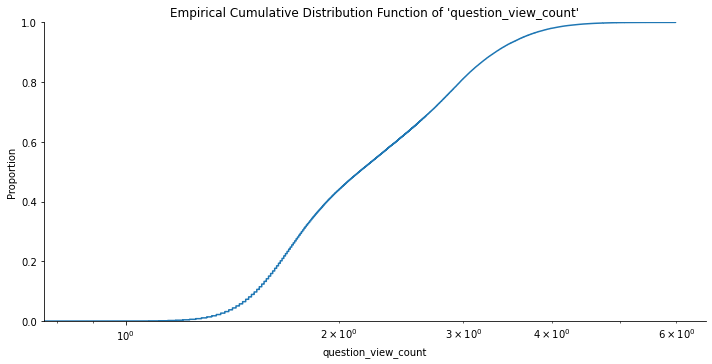

In [69]:
plt.figure()
sns.displot(x='question_view_count', data=so_QA_tags, kind='ecdf', height=5, aspect=2, log_scale=True)
plt.title("Empirical Cumulative Distribution Function of 'question_view_count'")
plt.show

#### <font color='red'>Setting popularity labels </font>
The distribution appears to skew to the right and the majority of the curve is far left of the mean (1211) and most posts will experience ~37 views. These metrics in tandem with a cumulative distribution plot can help us split the posts into 3 groups that represent 3 different sections of the distribution.  

Given a normal distribution, the 3 groups could be selected based on the mean and its standard deviations.  Because of the skewness, these metrics will not allow a simple division of the distribution. This is a problem because of how large the  is compared to the 
- mean = 1211 <br>
- 1 std = 7036 views <br>
- mode = 37 <br>
- max number of views = 965492 <br>
- min number of views = 7 <br>

This data naturally has a lot of outliers as seen in the distribution charts.  Based on the cumulative distribution plot, posts beyond ~37 views accounts for only 5% of the data.  The majority of the data is represented by posts that don't have more than 30 views.  

To solve our original problem we only need to determine what makes a post have an exceptionally high number of views as opposed to posts that see an average amount of views and those that barely see any views.  

Judging from the distribution plots, the sections can be broken down as such:

- top: question_view_count > 250
- mid: 15 < question_view_count < 250 
- bot: question_view_count < 15


*TOP*<br>
Posts that have an exceptionally high amount of views that account for ~10% of the data. These posts also happen to include the mean and posts that are several standard deviations above. 

*MIDDLE*<br>
Posts that includes the vast majority where views are.  These posts have an average amount of views and account for ~85% of the data

*BOTTOM*<br>
Posts that are barely viewed even though there is an acceptable answer.  These questions are rare likely due to the newness of the post or because the question is either too trivial, very specialized in nature, or some other unknown reason. 

-------------------------------
Labeling the posts based on these metrics will help us determine what key words in the question or answer affect the view counts for the posts that include the 'python' tag in the last 5 years.

In [70]:
so_QA_tags['dist_section'] = np.where(so_QA_tags['question_view_count'] > 250, 'Top', np.where(so_QA_tags['question_view_count'] > 15, 'Middle', 'Bottom'))
so_QA_tags['dist_section'].value_counts()

Middle    118576
Top        80514
Bottom       589
Name: dist_section, dtype: int64

### Beautiful Soup

In [71]:
# converting html to text

def soup_lxml(text):
  soup = BeautifulSoup(text, 'lxml')
  html_free = soup.get_text()
  return html_free

def soup_html(text):
  soup = BeautifulSoup(text, 'html.parser')
  html_free = soup.get_text()
  return html_free

def remove_next_line(text):
  new_text =  re.sub("\n", "", text)
  return new_text



In [72]:
# Initializing an example post as test data

test_html = so_QA_tags.loc[1, 'post_answer']
print(test_html)

<p>You create lists:</p>
<pre><code>accuracy = []
precision = []
recall = []
f1 = []
...
</code></pre>
<p>and you define scores to hold these lists:</p>
<pre><code>scores = [accuracy, precision, recall, f1]
</code></pre>
<p>Then you iterate over these lists:</p>
<pre><code>for score in scores:
   ...
</code></pre>
<p>But inside that loop you use these lists as if they're functions:</p>
<pre><code>score(y_test, predictions)
</code></pre>


#### Using different parsers to remove html tags

In [73]:

print("\n================== lxml ===================\n")
# using lxml parser

test_text_lxml = soup_lxml(test_html)
print(test_text_lxml)


print("\n===============  html.parser ===============\n")
# using html.parser parser

test_text_html = soup_html(test_html)
print(test_text_html)


================== lxml ===================

You create lists:
accuracy = []
precision = []
recall = []
f1 = []
...

and you define scores to hold these lists:
scores = [accuracy, precision, recall, f1]

Then you iterate over these lists:
for score in scores:
   ...

But inside that loop you use these lists as if they're functions:
score(y_test, predictions)


===============  html.parser ===============

You create lists:
accuracy = []
precision = []
recall = []
f1 = []
...

and you define scores to hold these lists:
scores = [accuracy, precision, recall, f1]

Then you iterate over these lists:
for score in scores:
   ...

But inside that loop you use these lists as if they're functions:
score(y_test, predictions)



#### Removing \n
When printed, the output will handle the \n as newlines.  This is not the same case when tokenizing an un-printed string.<br>
They will have to be removed and formatting will be lost when printing.

In [74]:
cleaned_text = remove_next_line(test_text_html)
cleaned_text

"You create lists:accuracy = []precision = []recall = []f1 = []...and you define scores to hold these lists:scores = [accuracy, precision, recall, f1]Then you iterate over these lists:for score in scores:   ...But inside that loop you use these lists as if they're functions:score(y_test, predictions)"

#### Extracting html elements like links
This should be done prior to extracting text since the tags need to be located. <br>
Create new soup.

In [75]:
test_soup = BeautifulSoup(test_html, "html.parser")
test_links = test_soup.find_all('a')
test_links

[]

2 ways to retrieve hyperlinks

In [76]:
for link in test_links:
  print("Text for hyperlink: {}".format(link.text))
  print("Attributes of links: {}".format(link.attrs))
  print("Link from href: {}".format(link.attrs['href']))

for link in test_soup.find_all('a'):
  print(link.get('href'))

#### Other Basic BeautifulSoup methods


In [77]:
# View the way tags are nested
print("============ prettify ============")
print(test_soup.prettify())

# Find titles
print("=========== title =============")
print(test_soup.title)

# Find p tags
print("============ p ============")
print(test_soup.p)

# Find links
print("=========== a =============")
print(test_soup.a)

# Find links
print("============ find_all a ============")
test_soup.find_all('a')

# Find text
print("=========== find_all text =============")
parsed_text = test_soup.find_all(text=True)
parsed_text

============ prettify ============
<p>
 You create lists:
</p>
<pre><code>accuracy = []
precision = []
recall = []
f1 = []
...
</code></pre>
<p>
 and you define scores to hold these lists:
</p>
<pre><code>scores = [accuracy, precision, recall, f1]
</code></pre>
<p>
 Then you iterate over these lists:
</p>
<pre><code>for score in scores:
   ...
</code></pre>
<p>
 But inside that loop you use these lists as if they're functions:
</p>
<pre><code>score(y_test, predictions)
</code></pre>
=========== title =============
None
============ p ============
<p>You create lists:</p>
=========== a =============
None
============ find_all a ============
=========== find_all text =============


['You create lists:',
 '\n',
 'accuracy = []\nprecision = []\nrecall = []\nf1 = []\n...\n',
 '\n',
 'and you define scores to hold these lists:',
 '\n',
 'scores = [accuracy, precision, recall, f1]\n',
 '\n',
 'Then you iterate over these lists:',
 '\n',
 'for score in scores:\n   ...\n',
 '\n',
 "But inside that loop you use these lists as if they're functions:",
 '\n',
 'score(y_test, predictions)\n']

#### Apply BeautifulSoup to post_question column to create cleaned up data

In [78]:
# use beautiful soup function to clean up html tags in the question
so_QA_tags['bSoup_question'] = so_QA_tags['post_question'].map(soup_html)

# use function to remove \n from raw question data
so_QA_tags['bSoup_question'] = so_QA_tags['bSoup_question'].map(remove_next_line)

In [79]:
so_QA_tags['bSoup_answer'] = so_QA_tags['post_answer'].map(soup_html).map(remove_next_line)

In [80]:
display(so_QA_tags['bSoup_question'].iloc[:2])
display(so_QA_tags['bSoup_answer'].iloc[:2])

0    I´m currently trying to customize the error ha...
1    I am creating a model using SVM. I wanted to s...
Name: bSoup_question, dtype: object

0    This is a first draft and the most naive solut...
1    You create lists:accuracy = []precision = []re...
Name: bSoup_answer, dtype: object

### NLTK

Using NLTK to clean up text and extract info to deterine the most used tokens.

In [81]:
import nltk
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [82]:
# remove_puncutation
def remove_punctuation(text):
  try:
    no_punct = "".join(c for c in text if c not in string.punctuation)
    return no_punct
  except (AttributeError, TypeError):
    raise AssertionError('Input variable should be a string')

In [83]:
ting_punc = pd.Series(data=["punc_STUFF like: ' ! @tag #tag %f 2^4 3*6 (par) They're ",
                            "! @ # $ % ^ & * ( ) - + ' . , / \ ",
                            "tokenize this $4 $tuff for me a of plz.."])
display(ting_punc)

0    punc_STUFF like: ' ! @tag #tag %f 2^4 3*6 (par...
1                   ! @ # $ % ^ & * ( ) - + ' . , / \ 
2             tokenize this $4 $tuff for me a of plz..
dtype: object

We may not want to remove punctuation that might degrade formulaic or programming notations.

In [84]:
# nltk tokenizer turns string into list of words
def tokenize_nltk(text, mode='default', case=None):
  """
  mode:
    space - tokenizes based on spaces as delimiters
    word - tokenizes based on words
    punkt - tokenizes based on punkt lexicon
  case:
    None - maintains case
    lower - transforms all tokens to lower case
  """
# ‘\w+|\$[\d\.]+|\S+’ # splits up by space or periods that are not attached to a digit

  if mode == 'space':
    nltk_tokenizer = RegexpTokenizer(r'\s+', gaps=True)
  
  elif mode == 'word':
    nltk_tokenizer = RegexpTokenizer(r'\w+')

  elif mode == 'default':
    tokenized = word_tokenize(text)

    if case == 'lower':
      print("lowering")
      tokenized_lower = [x.lower() for x in tokenized]
      print(type(tokenized))
      print(tokenized)
      #tokenized_lower = tokenized.lower()
      return tokenized_lower
    else:
      return tokenized

  if case == 'lower':
    tokenized = nltk_tokenizer.tokenize(text.lower())
  else:
    tokenized = nltk_tokenizer.tokenize(text)
  
  return tokenized

In [85]:
print("space")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='space'))
display(ting_toke)
print("word")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='word', case='lower'))
display(ting_toke)
print("default")
ting_toke = ting_punc.apply(lambda x: tokenize_nltk(x, mode='default', case='lower'))
display(ting_toke)


space


0    [punc_STUFF, like:, ', !, @tag, #tag, %f, 2^4,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2    [tokenize, this, $4, $tuff, for, me, a, of, pl...
dtype: object

word


0    [punc_stuff, like, tag, tag, f, 2, 4, 3, 6, pa...
1                                                   []
2       [tokenize, this, 4, tuff, for, me, a, of, plz]
dtype: object

default
lowering
<class 'list'>
['punc_STUFF', 'like', ':', "'", '!', '@', 'tag', '#', 'tag', '%', 'f', '2^4', '3*6', '(', 'par', ')', 'They', "'re"]
lowering
<class 'list'>
['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '+', "'", '.', ',', '/', '\\']
lowering
<class 'list'>
['tokenize', 'this', '$', '4', '$', 'tuff', 'for', 'me', 'a', 'of', 'plz..']


0    [punc_stuff, like, :, ', !, @, tag, #, tag, %,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2    [tokenize, this, $, 4, $, tuff, for, me, a, of...
dtype: object

In [86]:
# remove stopwords
def remove_stopwords(text):
  
  sans_stopwords = [word for word in text if word not in stopwords.words('english')]
  return sans_stopwords


In [87]:
ting_toke.apply(remove_stopwords)

0    [punc_stuff, like, :, ', !, @, tag, #, tag, %,...
1    [!, @, #, $, %, ^, &, *, (, ), -, +, ', ., ,, ...
2                     [tokenize, $, 4, $, tuff, plz..]
dtype: object

In [88]:
# nltk lemmatizer
def lemmatize_nltk(text):
  # Assert list of words
  
  lemmatizer = WordNetLemmatizer()
  lem_text = [lemmatizer.lemmatize(word) for word in text]
  return lem_text

In [89]:
pre_lem_string = pd.Series(data=[
                          "helping did these fights things were fighting"
])
pre_lem_words = pre_lem_string.apply(tokenize_nltk)
print(pre_lem_words)
lem_words = pre_lem_words.apply(lemmatize_nltk)
print(lem_words)

0    [helping, did, these, fights, things, were, fi...
dtype: object
0    [helping, did, these, fight, thing, were, figh...
dtype: object


In [90]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("fights")

'fight'

In [91]:
# nltk stemmer (Porter)
def porter_stemmer_nltk(text):
  # assert list of words
  stemmer = PorterStemmer()
  stemmed_text = [stemmer.stem(word) for word in text]
  
  return stemmed_text

In [92]:
stem_words = pre_lem_words.apply(porter_stemmer_nltk)
stem_words

0    [help, did, these, fight, thing, were, fight]
dtype: object

In [93]:
# complete function
def nltk_text_processing(pd_series, punc=False, stop=True, lem=True, stem=True):
  if isinstance(pd_series, pd.Series):
    print("pd_series is a Series")

    if punc:
      # remove punctuation.  string remains string
      pd_series = pd_series.apply(remove_punctuation)

    # tokenize.  string becomes list
    words = pd_series.apply(tokenize_nltk)
    print(f"words type: {type(words)}")
    
    if stop:
      # remove stopwords.  list remains list
      words = words.apply(remove_stopwords)
      print(f"sans_stopwords type: {type(words)}")
    
    if lem:
      # lemmatize.  list remains list
      words = words.apply(lemmatize_nltk)
      print(f"lemmatized type: {type(words)}")

    if stem:
      # stemmer. list remains list
      words = words.apply(porter_stemmer_nltk)
      print(f"stemmed type: {type(words)}")

    return words
    

In [94]:
so_QA_tags['bSoup_question'].iloc[:5]

0    I´m currently trying to customize the error ha...
1    I am creating a model using SVM. I wanted to s...
2    I created a form with Django forms. I implemen...
3    Snippet of my code implementation on PyTorch i...
4    I am trying to write a regex in Python for fin...
Name: bSoup_question, dtype: object

In [95]:
nltk_series = nltk_text_processing(so_QA_tags['bSoup_question'].iloc[:5], stem=False)
nltk_series

pd_series is a Series
words type: <class 'pandas.core.series.Series'>
sans_stopwords type: <class 'pandas.core.series.Series'>
lemmatized type: <class 'pandas.core.series.Series'>


0    [I´m, currently, trying, customize, error, han...
1    [I, creating, model, using, SVM, ., I, wanted,...
2    [I, created, form, Django, form, ., I, impleme...
3    [Snippet, code, implementation, PyTorch, :, mo...
4    [I, trying, write, regex, Python, finding, eve...
Name: bSoup_question, dtype: object

#### Use NLTK to find most common tokens in the questions, answers, and tags


#### NLTK N-Grams

Finding the most common tags
- split by delimiter "|"
- tokenize using sklearn.multilabelencoder
- count the max in each tag column



#### <font color='orange'>**Perform train test split for sample data and also reserve test data**</font>



In [96]:
so_QA_tags.columns

Index(['title', 'post_question', 'post_answer', 'question_answers',
       'question_comments', 'answer_comments', 'creation_date',
       'last_activity_date', 'question_score', 'answer_score', 'tags',
       'question_view_count', 'dist_section', 'bSoup_question',
       'bSoup_answer'],
      dtype='object')

In [97]:
so_QA_tags = so_QA_tags.reset_index(drop=False)

y = so_QA_tags['dist_section']
X = so_QA_tags.drop('dist_section', axis=1)

In [98]:
# sample 10 
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=.9, stratify=y, random_state=9) 
tts = [X_remaining, X_test, y_remaining, y_test]

X_train, X_validation, y_train, y_validation = train_test_split(X_remaining, y_remaining, test_size=.3, stratify=y_remaining, random_state=9) 
tts = [X_train, X_validation, y_train, y_validation]

In [99]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]


for dataset in tts:
  print(f"{namestr(dataset, globals())[0]:20} {dataset.shape}")

X_train              (13976, 15)
X_validation         (5991, 15)
y_train              (13976,)
y_validation         (5991,)


In [100]:
X_train = X_train.copy()
X_validation = X_validation.copy()


#### y_validation distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


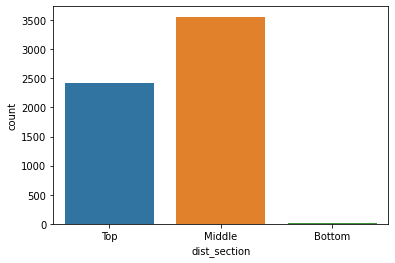

In [101]:
plt.figure()
sns.countplot(y_validation)
plt.show()

consider combining "Middle" and "Bottom"

#### Multi label binarizer for tags


In [102]:
from sklearn.preprocessing import MultiLabelBinarizer


In [156]:
# create tags_list column
X_train['tags_list'] = X_train['tags'].apply(lambda x: list(x.split('|')))
X_train['tags_list'].head(5)

X_validation['tags_list'] = X_validation['tags'].apply(lambda x: list(x.split('|')))
X_validation['tags_list'].head(5)

50405                                      [python, pandas]
175238    [python, validation, design-patterns, model, p...
130458                    [python, pandas, python-datetime]
172813                         [python, cx-freeze, pyside2]
191652                      [python-3.x, pandas, dataframe]
Name: tags_list, dtype: object

In [104]:
X_train_tags = X_train['tags_list']



In [105]:
mlb = MultiLabelBinarizer()
mlb_X_train_tags = mlb.fit_transform(X_train_tags)

In [106]:
mlb_tags_df = pd.DataFrame(mlb_X_train_tags, columns=mlb.classes_)
mlb_tags_df.head(5)

,.net,.net-3.5,128-bit,2d,2d-games,32bit-64bit,3d,3dsmax,64-bit,7zip,8-bit,aaa-security-protocol,abaqus,abc,absolute-path,abstract-class,abstract-methods,abstract-syntax-tree,accumulate,accumulator,ack,activation-function,active-directory,activepython,adafruit,adb,add,addition,adjacency-list,adjacency-matrix,admin,adodbapi,aerospike,aerospike-loader,affinetransform,aggregate,aggregation,aggregation-framework,aidl,aiohttp,...,xml-parsing,xml.etree,xmlhttprequest,xmltodict,xor,xpath,xpath-2.0,xslt,xterm,xticks,xvalue,xz,yacc,yahoo-finance,yaml,yapf,yaxis,ycsb,yield,yolo,yolov5,youtube,youtube-api,youtube-data-api,youtube-dl,z3,z3py,zappa,zbar,zeep,zelle-graphics,zeromq,zigzag,zip,zipfile,zipkin,zipline,zlib,zooming,zsh
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
# Extracting the tags with the highest counts
mlb_tags_df.iloc[:,:].sum().sort_values(ascending=False)[:10]

python        12656
python-3.x     2797
pandas         2316
django          924
numpy           831
dataframe       770
list            568
python-2.7      563
matplotlib      422
dictionary      379
dtype: int64

#### Another approach using sklearn's CountVectorizer
- Create a bag of words using count vectorizer

In [108]:
from sklearn.feature_extraction.text import CountVectorizer

In [109]:
# CountVectorizer needs to work with strings and not a list of tags
X_train_tags_str = X_train_tags.apply(lambda x: ' '.join(x))
X_train_tags_str

8919      python multithreading python-multiprocessing c...
57777                                                python
46669                                    python-3.x tkinter
65343                    python python-3.x string itertools
149073                         python circleci circleci-2.0
                                ...                        
84838                             python pandas time-series
2479                                      python json flask
195749                                      python function
27167                                      python dataframe
184452                                    python tensorflow
Name: tags_list, Length: 13976, dtype: object

In [110]:
skl_bagofwords = CountVectorizer()
fitted_bow = skl_bagofwords.fit_transform(X_train_tags_str)
fitted_bow

<13976x3248 sparse matrix of type '<class 'numpy.int64'>'
	with 46141 stored elements in Compressed Sparse Row format>

In [111]:
# Extracting tags as feature names
skl_cv_tags = skl_bagofwords.get_feature_names()
skl_cv_tags[:20]

['04',
 '10',
 '11',
 '12',
 '128',
 '13',
 '14',
 '16',
 '18',
 '2015',
 '2017',
 '2019',
 '264',
 '2d',
 '2to3',
 '301',
 '32bit',
 '3d',
 '3dsmax',
 '404']

In [112]:
# Convert sparse matrix to array
bow_array = fitted_bow.toarray()
bow_array.shape

(13976, 3248)

In [113]:
# create DataFrame similar to mlb_tags_df
skl_cv_tags_df = pd.DataFrame(data=bow_array, columns=skl_cv_tags)
skl_cv_tags_df.head()

,04,10,11,12,128,13,14,16,18,2015,2017,2019,264,2d,2to3,301,32bit,3d,3dsmax,404,405,410,422,64,64bit,754,76,7zip,aaa,abaqus,abc,absolute,abstract,access,accounts,accumulate,accumulator,ack,actions,activation,...,xlsx,xlsxwriter,xlwings,xlwt,xml,xmlhttprequest,xmltodict,xor,xpath,xslt,xterm,xticks,xvalue,xz,yacc,yahoo,yaml,yapf,yaxis,ycsb,yield,yolo,yolov5,yosemite,youtube,z3,z3py,zappa,zbar,zeep,zelle,zeromq,zigzag,zip,zipfile,zipkin,zipline,zlib,zooming,zsh
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
print(len(skl_cv_tags))
skl_counts = fitted_bow.toarray().sum(axis=0)
print(skl_counts)
print(type(skl_counts))


3248
[15 19  4 ...  3  2  2]
<class 'numpy.ndarray'>


In [115]:
skl_tag_counts = pd.DataFrame(data={'counts':skl_counts}, index=skl_cv_tags)
skl_tag_counts.T

,04,10,11,12,128,13,14,16,18,2015,2017,2019,264,2d,2to3,301,32bit,3d,3dsmax,404,405,410,422,64,64bit,754,76,7zip,aaa,abaqus,abc,absolute,abstract,access,accounts,accumulate,accumulator,ack,actions,activation,...,xlsx,xlsxwriter,xlwings,xlwt,xml,xmlhttprequest,xmltodict,xor,xpath,xslt,xterm,xticks,xvalue,xz,yacc,yahoo,yaml,yapf,yaxis,ycsb,yield,yolo,yolov5,yosemite,youtube,z3,z3py,zappa,zbar,zeep,zelle,zeromq,zigzag,zip,zipfile,zipkin,zipline,zlib,zooming,zsh
counts,15,19,4,6,1,1,4,5,6,2,2,1,1,6,1,1,1,3,1,3,1,1,1,1,1,1,1,2,1,1,3,1,6,4,4,2,1,1,2,1,...,3,10,7,3,71,1,1,1,53,2,1,1,1,1,1,1,18,1,1,1,4,4,1,1,13,2,2,2,1,1,1,6,1,11,4,1,1,3,2,2


In [116]:
skl_tag_counts.sort_values('counts', ascending=False).head(20)

,counts
python,16821
pandas,2437
django,1478
numpy,863
dataframe,776
list,630
matplotlib,427
dictionary,390
tensorflow,368
selenium,351


#### Plotting most frequent tags

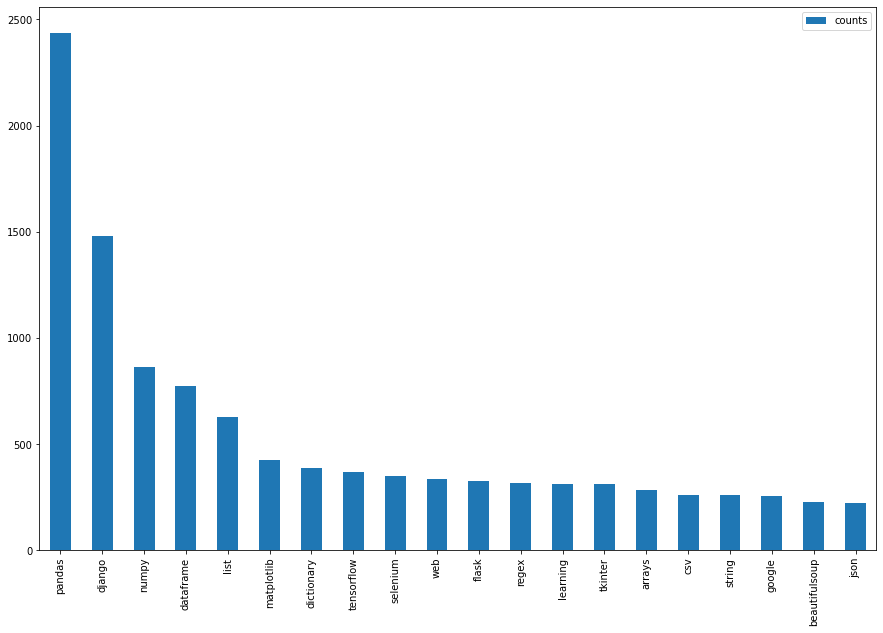

In [117]:
import matplotlib.pyplot as plt
# for top tags that are not "python"

fig, axs = plt.subplots(figsize=(.75*20, 10))
skl_tag_counts.drop('python').sort_values('counts', ascending=False).head(20).plot(kind='bar', ax=axs)

#### Word Cloud Plots

In [118]:
# top tags not including 'python'
top_tags = skl_tag_counts.drop('python').sort_values('counts', ascending=False).head(100)

In [119]:
top_dict = top_tags.to_dict()
top_dict = top_dict['counts']

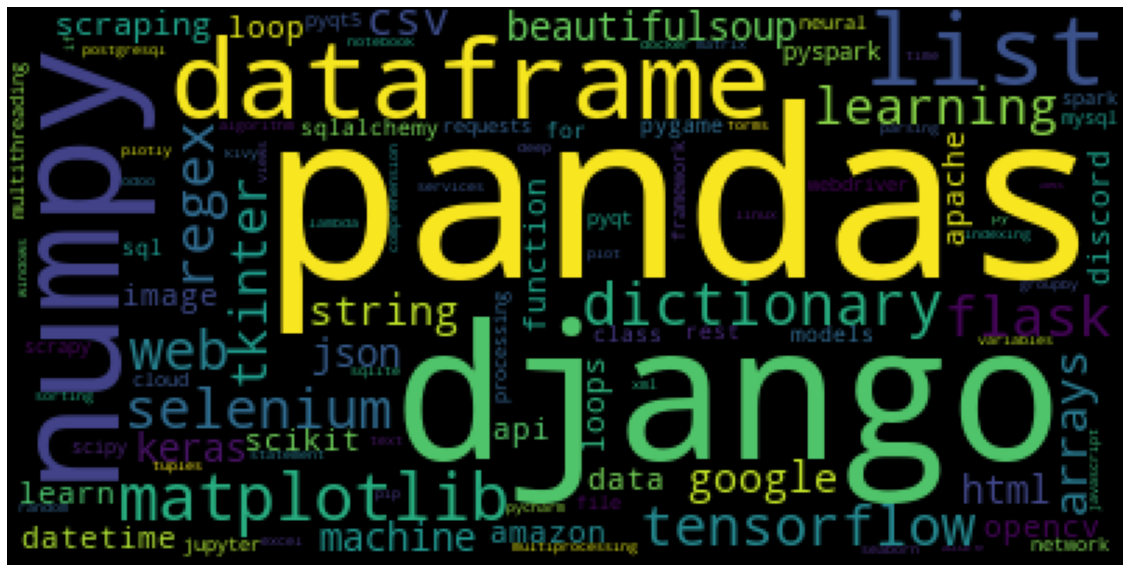

In [120]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=top_dict)

def plot_cloud(wordcloud):
  plt.figure(figsize=(20,20))
  plt.imshow(wordcloud)
  plt.axis("off")

plot_cloud(wordcloud)

### Spacy

Spacy intialization
- Initializing pipeline
- input text

In [121]:
print(spacy.__version__)
nlp = spacy.load('en')
print(nlp.pipe_names)

2.2.4
['tagger', 'parser', 'ner']


Reusing test data from beautiful soup output where html and nextlines were removed.


In [122]:
# using test_text that had the html lines removed and nextlines removed

print(cleaned_text)
doc = nlp(cleaned_text)
print(doc)

You create lists:accuracy = []precision = []recall = []f1 = []...and you define scores to hold these lists:scores = [accuracy, precision, recall, f1]Then you iterate over these lists:for score in scores:   ...But inside that loop you use these lists as if they're functions:score(y_test, predictions)
You create lists:accuracy = []precision = []recall = []f1 = []...and you define scores to hold these lists:scores = [accuracy, precision, recall, f1]Then you iterate over these lists:for score in scores:   ...But inside that loop you use these lists as if they're functions:score(y_test, predictions)


#### Tokenizer, Lemmatization and Stopword display
- token.lemma_
- token.is_stop

In [123]:
print(f"Token \t\tLemma \t\tStopword")
print("-"*40)
for token in doc:
  print(f"{str(token)}\t\t{token.lemma_}\t\t{token.is_stop}")


Token 		Lemma 		Stopword
----------------------------------------
You		-PRON-		True
create		create		False
lists		list		False
:		:		False
accuracy		accuracy		False
=		=		False
[		[		False
]		]		False
precision		precision		False
=		=		False
[		[		False
]		]		False
recall		recall		False
=		=		False
[		[		False
]		]		False
f1		f1		False
=		=		False
[		[		False
]		]		False
...		...		False
and		and		True
you		-PRON-		True
define		define		False
scores		score		False
to		to		True
hold		hold		False
these		these		True
lists		list		False
:		:		False
scores		score		False
=		=		False
[		[		False
accuracy		accuracy		False
,		,		False
precision		precision		False
,		,		False
recall		recall		False
,		,		False
f1]Then		f1]then		False
you		-PRON-		True
iterate		iterate		False
over		over		True
these		these		True
lists		list		False
:		:		False
for		for		True
score		score		False
in		in		True
scores		score		False
:		:		False
  		  		False
...		...		False
But		but		True
inside		inside		False
that		that		True
l

#### Matching Phrases
- captures token_id
- start and end positions

In [124]:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

key_terms = ['accuracy', 'precision', 'f1']
patterns =  [nlp(text) for text in key_terms]
matcher.add("TerminologyList", patterns)

In [125]:
print(test_text_html)
text_doc = nlp(test_text_html)
matches = matcher(text_doc)
print(matches)

You create lists:
accuracy = []
precision = []
recall = []
f1 = []
...

and you define scores to hold these lists:
scores = [accuracy, precision, recall, f1]

Then you iterate over these lists:
for score in scores:
   ...

But inside that loop you use these lists as if they're functions:
score(y_test, predictions)

[(3766102292120407359, 5, 6), (3766102292120407359, 10, 11), (3766102292120407359, 20, 21), (3766102292120407359, 40, 41), (3766102292120407359, 42, 43), (3766102292120407359, 46, 47)]


The matches are a tuple of (match_id, start pos, end pos)

In [126]:
match_id, start, end = matches[0]
print(nlp.vocab.strings[match_id], text_doc[start:end])

TerminologyList accuracy


- finding tags in a post entry
- using iterrows()

#### Bag of Words


In [127]:
nlp_default = spacy.load('en_core_web_sm')
print(nlp_default.pipe_names)


['tagger', 'parser', 'ner']


This model has prebuilt pipes.  We can add a text categorizer to this pipeline and see how it performs against models with just a text categegorizer that doesn't include a lemmatizer or even a tokenizer.

In [128]:
# This function adds a bag of words pipe to the pipeline
def add_bow_pipe(nlp):

  # create TextCategorizer with exclusive classes and "bow" (bag of words) architecture
  textcat = nlp.create_pipe(
      "textcat",
      config={
          # check other params
          "exclusive_classes": True,  # used if each row had known labels like "spam"
          "architecture": "bow"
      }
  )

  # Add bag of words pipe to nlp model
  nlp.add_pipe(textcat)

  # Add labels to the text classifier
  textcat.add_label("Top")
  textcat.add_label("Middle")
  textcat.add_label("Bottom")


In [129]:
nlp_question = spacy.blank('en')
add_bow_pipe(nlp_question)
nlp_answer = spacy.blank('en')
add_bow_pipe(nlp_answer)

add_bow_pipe(nlp_default)
print(nlp_default)
print(nlp_default.pipe_names)
print(nlp_question)
print(nlp_question.pipe_names)
print(nlp_answer)
print(nlp_answer.pipe_names)

['tagger', 'parser', 'ner', 'textcat']
['textcat']
['textcat']


These 3 models will be used to train on question and answer texts.  The default nlp model will be tested with just the question texts to compare when the default pipes are included along with the custom text categorizer. 

<br>
Additional difference can be seen in the details of the pipes

In [130]:
print(nlp_question.pipe_names)
print(nlp_question.pipe_labels)
print(nlp_question.pipe_factories)

print(nlp_default.pipe_names)
print(nlp_default.pipe_labels)
print(nlp_default.pipe_factories)

['textcat']
OrderedDict([('textcat', ['Top', 'Middle', 'Bottom'])])
{'textcat': 'textcat'}
['tagger', 'parser', 'ner', 'textcat']
OrderedDict([('tagger', ['$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'AFX', 'CC', 'CD', 'DT', 'EX', 'FW', 'HYPH', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'XX', '_SP', '``']), ('parser', ['ROOT', 'acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod', 'appos', 'attr', 'aux', 'auxpass', 'case', 'cc', 'ccomp', 'compound', 'conj', 'csubj', 'csubjpass', 'dative', 'dep', 'det', 'dobj', 'expl', 'intj', 'mark', 'meta', 'neg', 'nmod', 'npadvmod', 'nsubj', 'nsubjpass', 'nummod', 'oprd', 'parataxis', 'pcomp', 'pobj', 'poss', 'preconj', 'predet', 'prep', 'prt', 'punct', 'quantmod', 'relcl', 'xcomp']), ('ner', ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 

#### Apply Spacy to bSoup_questions column on X_train dataframe to prepare data for model
Recall that this data comes from the train test split and requires some isolation of the text data.

In [131]:
# Creating separate X_train dataset with just the question cleaned up through beautiful soup
X_train_question = X_train['bSoup_question']
X_train_answer = X_train['bSoup_answer']

X_validation_question = X_validation['bSoup_question']
X_validation_answer = X_validation['bSoup_answer']

# Verifying dataset shapes
print(X_train_question.shape)
print(X_train_answer.shape)
print(y_train.shape)

print(X_validation_question.shape)
print(X_validation_answer.shape)
print(y_validation.shape)

(13976,)
(13976,)
(13976,)
(5991,)
(5991,)
(5991,)


In [132]:
import random
from spacy.util import minibatch

def train_model(model, X_train, y_train, batch_size=256, epochs=5):
  # Creating train_data by zipping X_train with y_train
  train_text = X_train.values
  train_labels = [{'cats': {'Top': label =='Top',
                          'Middle': label == 'Middle',
                          'Bottom': label == 'Bottom'}}
                  for label in y_train]
  train_data = list(zip(train_text, train_labels))
  
  spacy.util.fix_random_seed(1)
  optimizer = model.begin_training()

  losses = {}
  for epoch in range(epochs):
    random.shuffle(train_data)

    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=batch_size)
    # Iterate through minibatches
    for batch in batches:
      # a batch is a tuple of (text, label) and needs to be split to be able to run update()
      texts, labels = zip(*batch)
      model.update(texts, labels, sgd=optimizer, losses=losses)

    print(losses)

  return model, losses

In [133]:
spacy_models = False

In [134]:
if spacy_models:
  print(nlp_question)
  nlp_question, losses_question = train_model(nlp_question, X_train_question, y_train, 256, 5)

  print(nlp_answer)
  nlp_answer, losses_answer = train_model(nlp_answer, X_train_answer, y_train, 256, 5)

  print(nlp_default)
  nlp_default, losses_default = train_model(nlp_default, X_train_question, y_train, 256, 5)

In [135]:
!ls

 nlp_answer_pipeline_epoch-5_batch-128	    nlp_pipeline_epoch-5_batch-128
 nlp_answer_pipeline_epoch-5_batch-256	    nlp_pipeline_epoch-5_batch-256
 nlp_answer_pipeline_epoch-5_batch-512	    nlp_pipeline_epoch-5_batch-512
'nlp_default_pipeline_epoch-5_batch-256 '   so_posts_QA_df.parquet.gzip
 nlp_default_pipeline_epoch-5_batch-512     so_posts_QA_feather
 nlp_pipeline_epoch-10_batch-512	    so_QA_tags.gzip


In [136]:
if spacy_models: 
  # QUESTIONS
  # May 14 epoch-5_batch-512
  # accuracy .414

  # May 14 epoch-5_batch-256
  # accuracy .421
  nlp_question.to_disk("nlp_pipeline_epoch-5_batch-256")


  # ANSWERS
  # May 14 epoch-5_batch-512
  # accuracy .439

  # May 14 epoch-5_batch-256
  # accuracy .428
  nlp_answer.to_disk("nlp_answer_pipeline_epoch-5_batch-256")


  # DEFAULT
  # May 14 epoch-5_batch-512
  # accuracy: .430

  # May 14 epoch-5_batch-256
  # accuracy .424
  nlp_default.to_disk("nlp_default_pipeline_epoch-5_batch-256 ")

# access validation data where the max of the array was the 3rd value


In [137]:
def predict(nlp, texts):
  docs = [nlp.tokenizer(text) for text in texts]

  textcat = nlp.get_pipe('textcat')
  scores, _ = textcat.predict(docs)

  predicted_class = scores.argmax(axis=1)
  print(scores)
  return predicted_class


def evaluate(model, texts, labels):
  predicted_class = predict(model, texts)
  true_class = np.where(labels == "Top", 2, np.where(labels == "Middle", 1, 0))
  correct_predictions = predicted_class == true_class
  print(correct_predictions)

  accuracy = correct_predictions.mean()
  print(accuracy)
  return accuracy, correct_predictions

In [138]:
if spacy_models:
  accuracy_question, correct_predictions_question = evaluate(nlp_question, X_validation_question, y_validation)
  accuracy_answer, correct_predictions_answer = evaluate(nlp_answer, X_validation_answer, y_validation)
  accuracy_default, correct_predictions_default = evaluate(nlp_default, X_validation_question, y_validation)

Extract info from model to evaluate scores beyond just accuracy

In [139]:
# nlp_question.textcat.tp

# scorer = nlp.evaluate(testset)
# TP = scorer.ner.tp
# FP = scorer.ner.fp
# FN = scorer.ner.fn

# scorer = nlp.evaluate(testset)
# for ent_type, scorer_ent_type in scorer.ner_per_ents.items():
#     TP = scorer_ent_type.tp
#     FP = scorer_ent_type.fp
#     FN = scorer_ent_type.fn
#     print('Ent_type:', ent_type, 'TP:', TP, 'FP:', FP, 'FN:', FN)

#### Conclusions



### SVC

X_train
y_train
X_validation
y_validation

record accuracy, precision, f1, roc, auc


In [157]:
print(f"X_train: \t{X_train.shape}")
print(f"y_train: \t{y_train.shape}")
print(f"X_validation: \t{X_validation.shape}")
print(f"y_validation: \t{y_validation.shape}")

X_train: 	(13976, 16)
y_train: 	(13976,)
X_validation: 	(5991, 16)
y_validation: 	(5991,)


In [154]:
X_train.columns

Index(['index', 'title', 'post_question', 'post_answer', 'question_answers',
       'question_comments', 'answer_comments', 'creation_date',
       'last_activity_date', 'question_score', 'answer_score', 'tags',
       'question_view_count', 'bSoup_question', 'bSoup_answer', 'tags_list'],
      dtype='object')

In [158]:
X_train_answer = X_train['bSoup_answer']

In [221]:
X_train.head(1)

,index,title,post_question,post_answer,question_answers,question_comments,answer_comments,creation_date,last_activity_date,question_score,answer_score,tags,question_view_count,bSoup_question,bSoup_answer,tags_list
8919,8919,python running coverage on never ending process,<p>I have a multi processed web server with pr...,"<p>Apparently, it is not possible to control <...",3,11,6,2016-09-14 08:23:37.547000+00:00,2017-04-15 18:59:20.917000+00:00,18,9,python|multithreading|python-multiprocessing|c...,2334,I have a multi processed web server with proce...,"Apparently, it is not possible to control cove...","[python, multithreading, python-multiprocessin..."


In [253]:
print("============first row and all columns============")
display(X_train.iloc[0])
print("============first row and 1st column============")
display(X_train.iloc[0, 1])
print("============first row and last column============")
display(X_train.iloc[0,-1])
print("============first row and columns 5-7 ============")
display(X_train.iloc[0,5:7])

============first row and all columns============


index                                                               8919
title                    python running coverage on never ending process
post_question          <p>I have a multi processed web server with pr...
post_answer            <p>Apparently, it is not possible to control <...
question_answers                                                       3
question_comments                                                     11
answer_comments                                                        6
creation_date                           2016-09-14 08:23:37.547000+00:00
last_activity_date                      2017-04-15 18:59:20.917000+00:00
question_score                                                        18
answer_score                                                           9
tags                   python|multithreading|python-multiprocessing|c...
question_view_count                                                 2334
bSoup_question         I have a multi processed web

============first row and 1st column============


'python running coverage on never ending process'

============first row and 8th column============


['python', 'multithreading', 'python-multiprocessing', 'coverage.py']

============first row and columns 5-7 ============


question_comments    11
answer_comments       6
Name: 8919, dtype: object

In [257]:
print("=========== first row and all columns =============")
display(X_train.loc[8919])
print("=========== first row and last columns =============")
display(X_train.loc[8919, 'tags_list'])
print("=========== first row and range of columns =============")
display(X_train.loc[8919, 'question_answers':'answer_score'])
print("=========== first row and specific columns =============")
display(X_train.loc[8919, ['tags', 'question_view_count']])
print("=========== rows with more than 10 answers and their tags =============")
display(X_train.loc[X_train['question_answers'] > 10, 'tags'])

=========== first row and all columns =============


index                                                               8919
title                    python running coverage on never ending process
post_question          <p>I have a multi processed web server with pr...
post_answer            <p>Apparently, it is not possible to control <...
question_answers                                                       3
question_comments                                                     11
answer_comments                                                        6
creation_date                           2016-09-14 08:23:37.547000+00:00
last_activity_date                      2017-04-15 18:59:20.917000+00:00
question_score                                                        18
answer_score                                                           9
tags                   python|multithreading|python-multiprocessing|c...
question_view_count                                                 2334
bSoup_question         I have a multi processed web

=========== first row and last columns =============


['python', 'multithreading', 'python-multiprocessing', 'coverage.py']

=========== first row and range of columns =============


question_answers                                     3
question_comments                                   11
answer_comments                                      6
creation_date         2016-09-14 08:23:37.547000+00:00
last_activity_date    2017-04-15 18:59:20.917000+00:00
question_score                                      18
answer_score                                         9
Name: 8919, dtype: object

=========== first row and specific columns =============


tags                   python|multithreading|python-multiprocessing|c...
question_view_count                                                 2334
Name: 8919, dtype: object

=========== rows with more than 10 answers and their tags =============


187075                     python|tensorflow|jupyter
198156    python|audio|machine-learning|theano|keras
42194                                         python
123046         python|python-2.7|pip|ssl-certificate
161693    python|csv|pandas|dataframe|file-not-found
158485                           python|models|spacy
137870         python|tensorflow|deep-learning|keras
36620                            python|list|sorting
Name: tags, dtype: object

Apply lemmatizer, stop words
maybe token regexp for functions


In [277]:
bagofwords_1 = CountVectorizer(stop_words='english')
bagofwords_2 = CountVectorizer(stop_words='english', token_pattern='\S+')



# preprocessor=None
# tokenizer=None
# stop_words=None
# token_pattern=
# ngram_range=(1,1)
# max_df=1.0
# min_df=1


In [278]:
X_train_transformed_1 = bagofwords_1.fit_transform(X_train_answer)
X_train_transformed_2 = bagofwords_2.fit_transform(X_train_answer)



In [279]:
words_1 = bagofwords_1.get_feature_names()
counts_1 = np.array(X_train_transformed_1.sum(axis=0))
X_train_bow_1_df = pd.DataFrame({"counts":counts_1[0]}, index=words_1)
X_train_bow_1_df

,counts
00,3071
000,380
0000,26
00000,11
000000,175
...,...
동작구,1
ｌｉｆｅ,1
ｌｉｆｅresources,1
ｎｃｃ,1


In [280]:
words_2 = bagofwords_2.get_feature_names()
counts_2 = np.array(X_train_transformed_2.sum(axis=0))
X_train_bow_2_df = pd.DataFrame({"counts": counts_2[0]}, index=words_2)
X_train_bow_2_df

,counts
!,28
!!,5
!!!,5
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,1
!!!#,1
...,...
�,3
"�"",(255,255,255),font=font)#",1
"�,",1
�=replacement,1


These tokens include a lot of numbers.  They can be removed by adding a preprocessor to the countvectorizer

In [289]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'_+', '', text)
  text = re.sub(r'(.)\1{3,}', '', text)
  return text

In [290]:
bagofwords_3 = CountVectorizer(stop_words='english', preprocessor=preprocess_text)
X_train_transformed_3 = bagofwords_3.fit_transform(X_train_answer)

In [293]:
words_3 = bagofwords_3.get_feature_names()
counts_3 = np.array(X_train_transformed_3.sum(axis=0))
X_train_bow_3_df = pd.DataFrame({"counts": counts_3[0]}, index=words_3)
display(X_train_bow_3_df.sort_values('counts', ascending=False))
display(X_train_bow_3_df.head(5))

,counts
self,11362
df,9863
print,7523
use,6925
import,6469
...,...
polymorphicon,1
ducky,1
duckling,1
polynomialfeatures,1


,counts
aa,125
aaa,77
aaaa,1
aaaaa,1
aaaaaazzzzzzzzzzzz,1


In [297]:
bagofwords_4 = CountVectorizer(stop_words='english', preprocessor=preprocess_text, min_df=2)
X_train_transformed_4 = bagofwords_4.fit_transform(X_train_answer)
words_4 = bagofwords_4.get_feature_names()
counts_4 = np.array(X_train_transformed_4.sum(axis=0))
X_train_bow_4_df = pd.DataFrame({"counts": counts_4[0]}, index=words_4)
display(X_train_bow_4_df.sort_values('counts', ascending=False).head(20))

,counts
self,11362
df,9863
print,7523
use,6925
import,6469
data,5815
list,4871
def,4794
python,4589
np,4516


### Isolating top words that are consisten with all questions:
Consider using tf-idf?
- self
- import
- print
- data
- python
- return
- code
- true


In [298]:
exclusion_list = ['self', 'import', 'print', 'data', 'python', 'return', 'code', 'true']

In [307]:
X_train_bow_4_df.drop(index=exclusion_list).sort_values('counts', ascending=False).head(15)

,counts
df,9863
use,6925
list,4871
def,4794
np,4516
value,4243
file,3662
using,3650
class,3501
need,3360


In [302]:
print(X_train_bow_4_df.shape)
print(len(X_train_bow_4_df.index))
X_train_bow_4_clipped = X_train_bow_4.

(18417, 1)
18417


### create n-grams with certain words
- use
- def
- need
- like
- class
- function

#### Spacy pt 2


In [ ]:
stop

In [142]:
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
from tqdm import tqdm

In [143]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [144]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

NameError: ignored

In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
from sklearn.model_selection import train_test_split

X = df_amazon['verified_reviews'] # the features we want to analyze
ylabels = df_amazon['feedback'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [ ]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

write a spacy function to extract elements of question or post:
- functions (include "." in the token)
- does it have a link? (beautiful soup)
- 

# OBJECTIVES
**BIGQUERY SQL**
<font color='lightgreen'>
- Last 5 years
- python tag
- has an accepted answer
- post_question, post_answer, question_answers, question_comments, answer_comments, question_score, answer_score, tags, creation date, last activity date, question_views
- sampled for 200,000 samples
</font>

**BEAUTIFUL SOUP**
<font color='lightgreen'>
- Removing HTML lines
</font>
- Does the presence of hyperlinks increase the views or scores?

**NLTK**
<font color='lightgreen'>
- what tokens appear the most per tag? (word cloud)
  - pandas, django, numpy, dataframe, list, matplotlib, dictionary, tensorflow, selenium, web, flask, regex, learning, tkinter, arrays, string, csv, google, beautifulsoup	
</font>


**SPACY**
<font color='lightgreen'>
- what tokens have the most views (word cloud)
- are post_question tokens better indicators of views or post_answer tokens?
 - question_answers
 - default nlp with added tokenizer performed better than isolated text categorizer
</font>
<font color='red'>
- use post title
</font>
- reimporting models
- Which tokens are the best predictors for predictions?
- what are the confusion matrix results?
- accessing .scorer entities
https://stackoverflow.com/questions/61214348/how-can-i-get-the-confusion-matrix-used-to-calculate-the-metrics-for-ner-models
- How are code lines tokenized?
- what POS (part of speech) is used for code?
- can named_entities be used to identify which swords are most commonly used as examples? (animals, fruits, countries, names)
- use DisplaCy for visual annotations in text
- use updated SpaCy modules

**SVC**
- what tokens / concepts have the highest coefficients for "Top" views (SVC)
  - ngrams
  - lemmed
  - spacy tokenizer
  - TFID

**ENSEMBLE**
- what features best predict the # of views?


**OTHER**
- most common functions (SpaCy)
- use networkx to create knowledge graph tying python related tags
- visualizations





